In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [66]:
mails = pd.read_csv('spam.csv', encoding = "latin-1")
mails.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [67]:
mails.drop('Unnamed: 2', axis = 1, inplace = True)
mails.drop('Unnamed: 3', axis = 1, inplace = True)
mails.drop('Unnamed: 4', axis = 1, inplace = True)

In [68]:
mails.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [69]:
mails.columns = ['label', 'message']

In [70]:
mails.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
mails[mails['label'] == 'spam']

,label,message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


# Exploratory Data Analysis

In [71]:
mails.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [72]:
mails.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [73]:
mails['length'] = mails['message'].apply(len)

In [74]:
mails.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


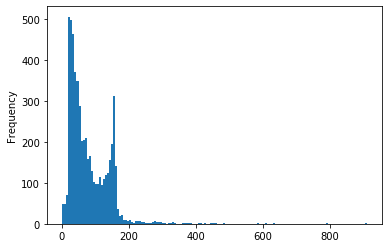

In [75]:
mails['length'].plot.hist(bins = 150)

In [76]:
mails['length'].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

In [77]:
mails[mails['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8e4c6b910>,
      dtype=object)

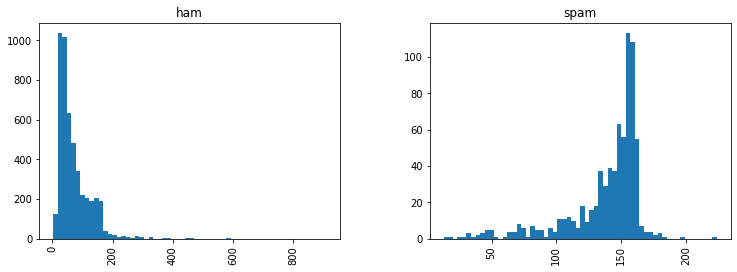

In [78]:
mails.hist(column='length', by = 'label', bins = 60, figsize = (12,4))

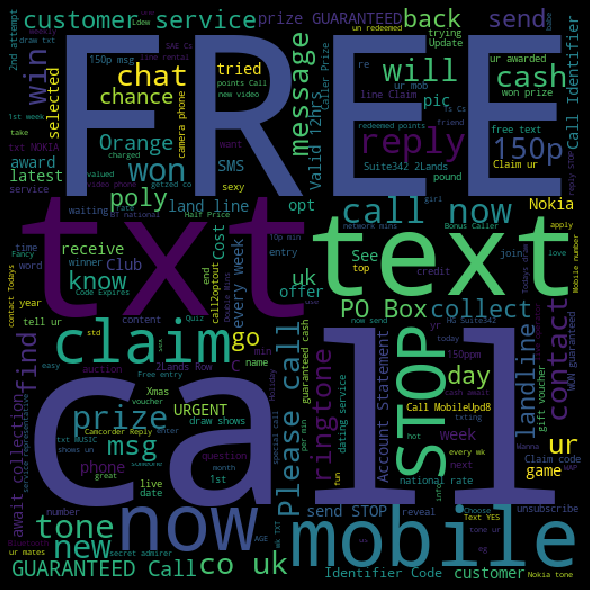

In [79]:
spam_words = ''.join(list(mails[mails['label'] == 'spam']['message']))
spam_wc = WordCloud(width = 512, height = 512).generate(spam_words)
plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

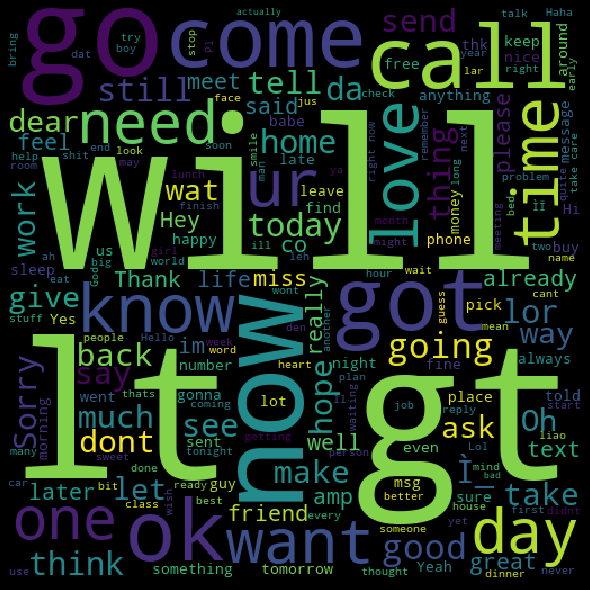

In [80]:
spam_words = ''.join(list(mails[mails['label'] == 'ham']['message']))
spam_wc = WordCloud(width = 512, height = 512).generate(spam_words)
plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

# Model Training and Prediction including NLP steps

In [81]:
def text_process(mail):
    """
    1.remove punctuation
    2.remove stop words
    3.perform stemming
    3. return list of clean text words
    """
    nopunc = [char for char in mail if char not in string.punctuation]
    
    nopunc = ''.join(nopunc)
    
    words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    return words

In [96]:
#Splitting the data into train and test data

message_train, message_test, label_train, label_test = train_test_split(mails['message'], mails['label'], test_size = 0.25)

In [98]:
#Creating a pipeline with all preprocessing steps and model classifiers.

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer = text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

In [100]:
pipeline.fit(message_train, label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7fc8edb05710>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [101]:
predictions = pipeline.predict(message_test)

In [103]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.97      1205
        spam       1.00      0.67      0.80       188

    accuracy                           0.96      1393
   macro avg       0.98      0.84      0.89      1393
weighted avg       0.96      0.96      0.95      1393



In [105]:
pipeline_rf =  Pipeline([
    ('bow', CountVectorizer(analyzer = text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier())
])

In [106]:
pipeline_rf.fit(message_train, label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7fc8edb05710>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.

In [107]:
predictions_rf = pipeline_rf.predict(message_test)

In [108]:
print(classification_report(label_test, predictions_rf))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1205
        spam       1.00      0.77      0.87       188

    accuracy                           0.97      1393
   macro avg       0.98      0.89      0.93      1393
weighted avg       0.97      0.97      0.97      1393



In [111]:
from sklearn.linear_model import LogisticRegression

pipeline_log = Pipeline([
    ('bow', CountVectorizer(analyzer = text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression())
])

In [112]:
pipeline_log.fit(message_train, label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7fc8edb05710>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b...
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                            

In [113]:
predictions_log = pipeline_log.predict(message_test)

In [114]:
print(classification_report(label_test, predictions_log))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.97      1205
        spam       0.98      0.66      0.79       188

    accuracy                           0.95      1393
   macro avg       0.97      0.83      0.88      1393
weighted avg       0.95      0.95      0.95      1393

